# Open Street Map

By making use of the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library we can fetch [OpenStreetMap](https://www.openstreetmap.org/) data and use it in MGSurvE! This time, we will start by loading the library and setting up some of its internal parameters:

In [12]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
import osmnx as ox
import numpy as np
import pandas as pd
from math import exp
from copy import deepcopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
import warnings
warnings.filterwarnings("ignore")
ox.settings.log_console=False
ox.settings.use_cache=True
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('Banfora', './out/')
srv.makeFolder(OUT_PTH)

## Downloading Buildings Footprints

In this example, we will download the data of a section of Banfora, Burkina Faso. To do this, we will center our reference point at the `(110.63524, -4.75195)` coordinates and set an altitude of `250` meters:

In [10]:
(COORDS, DIST) = ((10.63524, -4.75195), 250)
# Scrape building footprints to dataframe -------------------------------------
BLD = ox.features.features_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


The `BLD` dataframe contains all the information we need to generate a map of the location and we can, additionally, plot the roads by projecting the `NTW` graph:

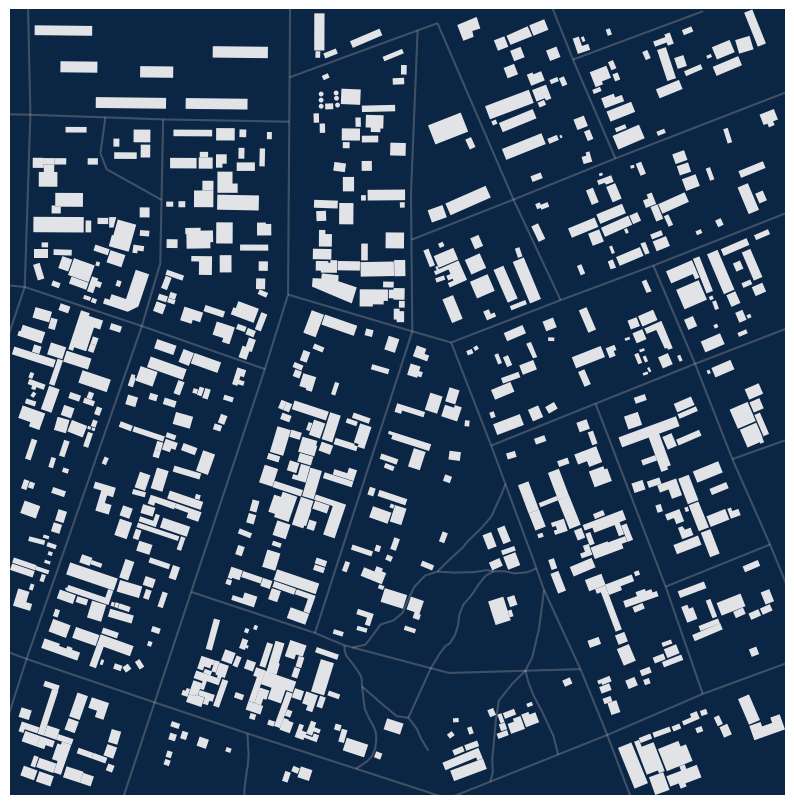

In [6]:
STYLE_BG = {'color': '#0b2545'}
STYLE_BD = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
# Project and plot map --------------------------------------------------------
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

## Generating MGSurvE Landscape

If we wanted to make use of our data in MGSurvE, one simple way we can go about it is by using the `centroid_lon` and `centroid_lat` to generate our migration matrix and landscape:

In [7]:
lonLats = np.array(list(zip(BLD['centroid_lon'], BLD['centroid_lat'])))
migDst = srv.calcDistanceMatrix(lonLats, distFun=srv.haversineDistance)

This time, we will define a custom exponential kernel. To do this we just need to define a function that takes the distance matrix as an argument, applies a function upon it based on the distance between every pair-wise combination of points (an exponential decay one, in this case), and returns a row-normalized migration probability matrix:

In [8]:
# Defining our custom migration kernel ----------------------------------------
def exponentialKernel(distMat, decay):
    coordsNum = len(distMat)
    migrMat = np.empty((coordsNum, coordsNum))
    for (i, row) in enumerate(distMat):
        for (j, dst) in enumerate(row):
            migrMat[i][j] = exp(-decay*dst)
        for j in range(len(row)):
            if np.isnan(migrMat[i][j]):
                migrMat[i][j] = 0
    tauN = normalize(migrMat, axis=1, norm='l1')
    return tauN
# Calculating the full migration matrix ---------------------------------------
MEAN_LIFETIME_DISPERSAL = 25
migMat = exponentialKernel(migDst, 1/MEAN_LIFETIME_DISPERSAL)

We now generate our sites dataframe:

In [6]:
# Generate sites dataframe ----------------------------------------------------
sites = pd.DataFrame(lonLats, columns=['lon', 'lat'])
sites['t'] = [0]*sites.shape[0]
# Get the bounding box and centroid -------------------------------------------
BBOX = (
    (min(sites['lon']), max(sites['lon'])),
    (min(sites['lat']), max(sites['lat']))
)
CNTR = [i[0]+(i[1]-i[0])/2 for i in BBOX]

And define the traps we want to optimize:

In [7]:
TRPS_NUM = 5
(initLon, initLat) = (COORDS[0]*TRPS_NUM, COORDS[1]*TRPS_NUM)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': [0]*TRPS_NUM, 'f': [0]*TRPS_NUM
})
tKer = {0:{'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

With these pieces in place, we can now define our landscape object:

In [8]:
lnd = srv.Landscape(
    sites, migrationMatrix=migMat,
    traps=traps, trapsKernels=tKer, landLimits=BBOX,
    trapsRadii=[0.250, 0.125, 0.100],
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

## Optimizing 

We will run discrete optimization upon our landscape as follows:

In [9]:
GENS = 250
VERBOSE = True
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
lndGA = deepcopy(lnd)
# Running GA and exporting results --------------------------------------------
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lndGA, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)
srv.exportLog(logbook, OUT_PTH, '{}_LOG'.format(ID))
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

gen	nevals	min    	avg    	max    	std    	best	traps                    
0  	75    	32.7963	49.7578	121.601	14.3667	22  	[327, 251, 215, 627, 488]
1  	46    	32.7963	43.0925	82.8272	7.59363	10  	[327, 251, 215, 627, 488]
2  	38    	32.7963	39.8661	65.042 	5.5852 	0   	[327, 251, 215, 627, 488]
3  	50    	31.4522	40.5908	71.9353	8.0034 	45  	[436, 474, 138, 669, 146]
4  	39    	31.4522	38.2536	55.5053	5.00515	49  	[436, 474, 138, 669, 146]
5  	34    	31.4522	38.5431	86.8184	9.18626	34  	[436, 474, 138, 669, 146]
6  	42    	29.6978	37.333 	60.4879	6.21692	54  	[429, 295, 138, 669, 448]
7  	30    	29.8946	36.4155	64.7277	6.39264	54  	[429, 295, 297, 669, 448]
8  	40    	29.8946	36.7227	67.4428	7.14487	33  	[429, 295, 297, 669, 448]
9  	43    	29.8946	36.0895	70.0696	7.19543	40  	[429, 295, 297, 669, 448]
10 	52    	29.8946	38.1203	76.1316	9.10915	62  	[429, 295, 297, 669, 448]
11 	30    	30.0093	37.0385	93.2193	10.4157	12  	[436, 295, 138, 669, 475]
12 	41    	29.6978	37.1257	85.8329	10.

And plot our results!

NameError: name 'lnd' is not defined

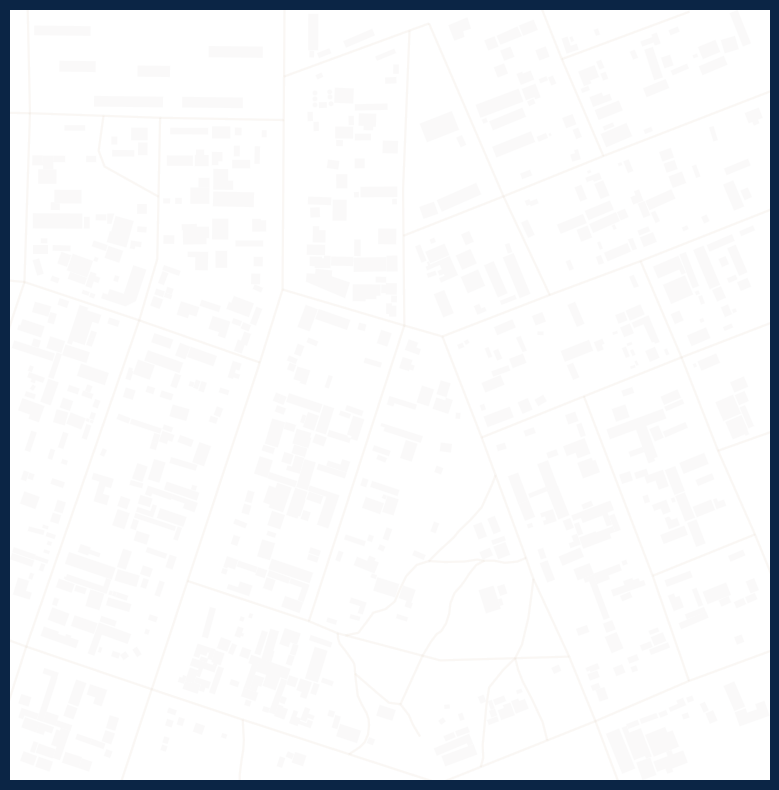

In [13]:
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lnd.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)